In [1]:
import numpy as np
from cosmoTransitions import generic_potential
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.integrate as integrate
import random
from scipy import interpolate, special

####Some definitions##
v2 = 246.2**2
mh=125.09
v=246.2
alpha=1/137
sinthw=np.sqrt(0.223)
g1=np.sqrt(4*np.pi*alpha/(1-sinthw**2))
g=np.sqrt(4*np.pi*alpha)/sinthw
Mplanck=2.4*10**18

class model1(generic_potential.generic_potential):
    def init(self, ms = 50, theta = 0, muhs = 0, u = 100, mu3 = 0):
        self.Ndim = 2
        self.renormScaleSq = 1000**2
        self.ms = ms
        self.theta = theta
        self.muhs = muhs
        self.u = u
        self.mu3 = mu3
        self.lamh = 1/(4*v2)*(mh**2+self.ms**2 + (mh**2 - ms**2)*np.cos(2*self.theta))
        self.lams = 1/(4*self.u**3)*(mh**2*self.u + ms**2*self.u + 2*self.u**2*self.mu3 + v**2*self.muhs - (mh**2-ms**2)*self.u*np.cos(2*self.theta))
        self.lammix = 1/(v*self.u)*(-(self.ms**2-mh**2)*np.sin(self.theta)*np.cos(self.theta) - self.muhs*v)
        self.muh2 = self.lamh*v2 + self.muhs*self.u + self.lammix/2*self.u**2
        self.mus2 = -self.mu3*self.u + self.lams*self.u**2 + self.muhs*v2/(2*self.u) + self.lammix/2*v2
        
    def find_counter_terms(self):
        """Method to find the coefficients of the counterterms taking into account running of the couplings"""
        def potential_CW(h,s):
            """Coleman-Weinberg potential evaluated at [h,s]"""
            mu=self.renormScaleSq**0.5
            muh=self.muh2
            mus=self.mus2
            lammix=self.lammix
            lam=self.lamh
            lams=self.lams
            mu3=self.mu3
            muhs=self.muhs
            ###Mass matrix elements
            a=3*h**2*lam + s**2*lammix/2 - muh + s*muhs
            b=h**2*lammix/2 + 3*s**2*lams - mus -2*s*mu3
            c=h*s*lammix + h*muhs
            ###Field dependent masses
            mp=(a+b)/2 + np.sqrt((a-b)**2/4 + c**2)
            mm=(a+b)/2 - np.sqrt((a-b)**2/4 + c**2)
            mz=(g1**2+g**2)*h**2/4
            mw=g**2*h**2/4
            mt=h**2/2
            ###CW potential
            VCW=mp**2*(np.log(np.sqrt(mp**2)/mu**2)-3/2)+mm**2*(np.log(np.sqrt(mm**2)/mu**2)-3/2)
            VCW+=3*mz**2*(np.log(np.sqrt(mz**2)/mu**2)-5/6) +6*mw**2*(np.log(np.sqrt(mw**2)/mu**2)-5/6)
            VCW+=-12*mt**2*(np.log(np.sqrt(mt**2)/mu**2)-3/2)
            return VCW/(64*np.pi**2)
        def grad_V_1loop(X):
            """first and second derivatives of the 1-loop potential at EW vacuum (h=v,s=w)"""
            w=self.u
            fun_h=lambda h: potential_CW(h,w)
            fun_s=lambda s: potential_CW(v,s)
            fun_hs=lambda h,s: potential_CW(h,s)
            dV_dh=lambda h: deriv(h,fun_h)
            dV_ds=lambda s: deriv(s,fun_s)
            d2V_dh2=deriv(v,dV_dh)
            d2V_ds2=deriv(w,dV_ds)
            d2V_dsh=deriv_2nd([v,w],fun_hs)
            return [dV_dh(v),dV_ds(w),d2V_dh2,d2V_ds2,d2V_dsh]
        
        def print_counter_terms(X):
            """for given input parameters, return the coefficients of the counter terms """
            w=self.u
            V_derivatives=grad_V_1loop([v,w])
            dmuh=(3*V_derivatives[0] - w*V_derivatives[4] - v*V_derivatives[2])/(2*v)
            dmus=(-3*V_derivatives[1] + w*V_derivatives[3] + v*V_derivatives[4])/(2*w)
            dlam=(V_derivatives[0] - v*V_derivatives[2])/(2*v**3)
            dlams=(-w*V_derivatives[3]+V_derivatives[1])/(2*w**3)
            dlammix=(-V_derivatives[4])/(v*w)
            return [dmuh,dmus,dlam,dlams,dlammix]

        self.counter_terms=print_counter_terms([v,self.u])
        print("Counter terms are given by: \n")
        print("[dmuh,dmus,dlam,dlams,dlammix]")
        print(self.counter_terms)
        print("..............\n Derivatives of CW potential are given by:")
        print(grad_V_1loop([v,self.u]))
        print("value of CW at the minimum")
        print(potential_CW(v,self.u))

        
    def forbidPhaseCrit(self, X):
        return any([np.array([X])[...,0] < -5.0, np.array([X])[...,1] < -5.0])
    
    def V0(self, X):
        X = np.asanyarray(X)
        h, s = X[...,0], X[...,1]
        pot = -1/2*self.muh2*h**2 + 1/4*self.lamh*h**4 - 1/2*self.mus2*s**2 - 1/3*self.mu3*s**3 + 1/4*self.lams*s**4 + 1/2*self.muhs*h**2*s + 1/4*self.lammix*h**2*s**2
        dmuh,dmus,dlam,dlams,dlammix = self.counter_terms
        VCT = potential_CT(dmuh,dmus,dlam,dlams,dlammix,h,s)
        return pot+VCT
    
    
    def old_boson_massSq(self, X, T): 
        X = np.array(X)
        h, s = X[...,0], X[...,1]

        #####Scalar thermal masses##
        Pi_h = T**2*(g1**2/16 + 3*g**2/16 + self.lamh/2 + 1/4 + self.lammix/24)
        Pi_s= T**2*(self.lammix/6 + self.lams/4)
     
        ##Scalar mass matrix##
        a= -self.muh2 + 3*self.lamh*h**2 + self.muhs*s + 1/2*self.lammix*s**2 + Pi_h
        b= -self.mus2 - 2*self.mu3*s + 3*self.lams*s**2 + 1/2*self.lammix*h**2 + Pi_s
        cc=h*s*self.lammix + self.muhs*h
        A=(a+b)/2
        B=1/2*np.sqrt((a-b)**2+4*cc**2)
        m1=A+B
        m2=A-B
        
        ####Gauge boson masses
        mW = g**2*h**2/4 + 11/6*g**2*T**2
        ag=g**2*h**2/4 + 11/6*g**2*T**2
        bg=1/4*g1**2*h**2 + 11/6*g1**2*T**2
        ccg=-1/4*g1*g*h**2
        Ag=(ag+bg)/2
        Bg=1/2*np.sqrt((ag-bg)**2+4*ccg**2)
        mZ=Ag+Bg
        mPh=Ag-Bg

        M = np.array([m1,m2,mW,mZ])
        if self.ms<mh:
            Mphys = np.array([mh**2,self.ms**2,g**2*v**2/4,v**2/4*(g**2+g1**2)])
        else:
            Mphys = np.array([self.ms**2,mh**2,g**2*v**2/4,v**2/4*(g**2+g1**2)])

        # At this point, we have an array of boson masses, but each entry might
        # be an array itself. This happens if the input X is an array of points.
        # The generic_potential class requires that the output of this function
        # have the different masses lie along the last axis, just like the
        # different fields lie along the last axis of X, so we need to reorder
        # the axes. The next line does this, and should probably be included in
        # all subclasses.
        M = np.rollaxis(M, 0, len(M.shape))
        Mphys = np.rollaxis(Mphys, 0, len(Mphys.shape))

        # The number of degrees of freedom for the masses. This should be a
        # one-dimensional array with the same number of entries as there are
        # masses.

        dof = np.array([1,1,6,3])


        # c is a constant for each particle used in the Coleman-Weinberg
        # potential using MS-bar renormalization. It equals 1.5 for all scalars
        # and the longitudinal polarizations of the gauge bosons, and 0.5 for
        # transverse gauge bosons.
        #c = np.array([1.5,1.5,1.5,1.5,1.5,1.5,1.5])
        c = np.array([1.5,1.5,5/6,5/6])
        
        return M, dof, c
    
    def boson_massSq(self, X, T):
        X = np.array(X)
        h, s = X[...,0], X[...,1]

       #####Scalar thermal masses, obtained from appendix of 1702.06124
        Pi_h = T**2*(g1**2/16 + 3*g**2/16 + self.lamh/2 + 1/4 + self.lammix/24)
        Pi_s= T**2*(self.lammix/6 + self.lams/4)
     
        ##Scalar mass matrix##
        a=3*h**2*self.lamh + s**2*self.lammix/2 - self.muh2 + s*self.muhs + Pi_h
        b=h**2*self.lammix/2 + 3*s**2*self.lams - 2*s*self.mu3 - self.mus2 + Pi_s
        cc=h*s*self.lammix  + h*self.muhs
        A=(a+b)/2
        B=1/2*np.sqrt((a-b)**2+4*cc**2)
        m1=A+B
        m2=A-B
        
        ####Gauge boson masses (Longitudinal)
        mWL = g**2*h**2/4 + 11/6*g**2*T**2
        ag=g**2*h**2/4 + 11/6*g**2*T**2
        bg=1/4*g1**2*h**2 + 11/6*g1**2*T**2
        ccg=-1/4*g1*g*h**2
        Ag=(ag+bg)/2
        Bg=1/2*np.sqrt((ag-bg)**2+4*ccg**2)
        mZL=Ag+Bg
        mPh=Ag-Bg


        M = np.array([m1,m2,g**2*h**2/4,h**2/4*(g**2+g1**2),mWL,mZL])
        if self.ms<mh:
            Mphys = np.array([mh**2,self.ms**2,g**2*v**2/4,v**2/4*(g**2+g1**2),g**2*v**2/4,v**2/4*(g**2+g1**2)])
        else:
            Mphys = np.array([self.ms**2,mh**2,g**2*v**2/4,v**2/4*(g**2+g1**2),g**2*v**2/4,v**2/4*(g**2+g1**2)])

        # At this point, we have an array of boson masses, but each entry might
        # be an array itself. This happens if the input X is an array of points.
        # The generic_potential class requires that the output of this function
        # have the different masses lie along the last axis, just like the
        # different fields lie along the last axis of X, so we need to reorder
        # the axes. The next line does this, and should probably be included in
        # all subclasses.
        M = np.rollaxis(M, 0, len(M.shape))
        Mphys = np.rollaxis(Mphys, 0, len(Mphys.shape))

        # The number of degrees of freedom for the masses. This should be a
        # one-dimensional array with the same number of entries as there are
        # masses.

        dof = np.array([1,1,4,2 , 2,1]) ##Longitudinal at the end
 

        # c is a constant for each particle used in the Coleman-Weinberg
        # potential using MS-bar renormalization. It equals 1.5 for all scalars
        # and the longitudinal polarizations of the gauge bosons, and 0.5 for
        # transverse gauge bosons.
        #c = np.array([1.5,1.5,1.5,1.5,1.5,1.5,1.5])
        c = np.array([1.5,1.5,5/6,5/6,5/6,5/6])

        return M, dof, c
    
    def fermion_massSq(self, X):
        X = np.array(X)
        h,s = X[...,0], X[...,1]
        mt=h**2/2
        M = np.array([mt])
        Mphys = np.array([v**2/2])

        # At this point, we have an array of boson masses, but each entry might
        # be an array itself. This happens if the input X is an array of points.
        # The generic_potential class requires that the output of this function
        # have the different masses lie along the last axis, just like the
        # different fields lie along the last axis of X, so we need to reorder
        # the axes. The next line does this, and should probably be included in
        # all subclasses.
        M = np.rollaxis(M, 0, len(M.shape))
        Mphys = np.rollaxis(Mphys, 0, len(Mphys.shape))
        
        dof = np.array([12])
        return M, dof
    

    def approxZeroTMin(self):
        # There are generically two minima at zero temperature in this model,
        # and we want to include both of them.
        v = v2**.5
        return [np.array([v,self.u]), np.array([-v,-self.u]),np.array([v,-self.u]),np.array([-v,self.u])]
    
    def theory_consistent(self):
        """Test if the model is is allowed by positivity and perturbativity. Returns a boolean"""
        plimit=4*np.pi
        lamh_tot=self.lamh+self.counter_terms[2]
        lams_tot=self.lams + self.counter_terms[3]
        lammix_tot=self.lammix + self.counter_terms[4]
        perturbativity=lamh_tot<=plimit and lams_tot<=plimit and lammix_tot<=plimit
        positivity=(lamh_tot>0) and (lams_tot>0) and (lammix_tot>-2*(lamh_tot*lams_tot)**.5)
        if perturbativity and positivity:
            print("Model is theoretically consistent \n")
            return True
        else:
            print("Model is NOT theoretically consistent \n")
            return False
            
        
    def print_couplings(self):
        """Print the numerical values of the tree level potential (including the counter terms) and the input
        parameters of the model"""
        lamh_tot=self.lamh+self.counter_terms[2]
        lams_tot=self.lams + self.counter_terms[3]
        lammix_tot=self.lammix + self.counter_terms[4]
        muh2_total = self.muh2+self.counter_terms[0]
        mus2_total = self.mus2+self.counter_terms[1]
        print("Potential parameters are given by \n ")
        print("mus2=",self.mus2, "muh2=",self.muh2,"lamh=",self.lamh,"lams=",self.lams,"lammix=",self.lammix,"\n")
        print("Model parameters are \n")
        print("ms=",self.ms,"theta=",self.theta,"muhs=",self.muhs,"u=",self.u,"mu3=",self.mu3)


    
    
######MY FUNCTIONS START HERE---------    
def deriv(x,f,eps=0.001,order=4):
    """This function calculates the derivative of a function f(x) wrt x."""
    if order==4:
        dx = np.array([-2., -1., 1., 2.])*eps
        coef = np.array([1., -8., 8., -1. ])/(12.*eps)
    elif order==2:    
        dx = np.array([ 1., -1.])*eps
        coef = np.array([1, -1 ])/(2.*eps)
    elif order==6:    
        dx = np.array([-3., -2., -1., 1., 2.,3.])*eps
        coef = np.array([-1., 9., -45., 45., -9.,1. ])/(60.*eps)
    else: #order 8
        dx = np.array([-4.,-3., -2., -1., 1., 2.,3.,4.])*eps
        coef = np.array([3.,-32., 168.,-672., 672., -168., 32.,-3. ])/(840.*eps)
    f_list = []
    for i in dx:
        f_list.append(f(x+i))
    action_output = np.array(f_list)
    return np.sum(action_output*coef)

def deriv_2nd(x,f,epsx=0.001,epsy=0.001):
    """This function calculates the second derivative of a function f(x,y) wrt dx dy.
    -------
    Parameters:
    f: a function of two variables f(x,y)
    x: a list of floats with the coordinates [x,y]
    ----
    Returns:
    df_dxdy: a float"""
    dx = np.array([1., -1., 1.,-1])*epsx
    dy = np.array([1., -1., -1.,1])*epsy
    coef = np.array([1., 1., -1.,-1 ])/(4.*epsx*epsy)
    f_list = []
    for i in range(len(dx)):
        f_list.append(f(x[0]+dx[i],x[1]+dy[i]))
    action_output = np.array(f_list)
    return (np.sum(action_output*coef))

def potential_CT(dmuh,dmus,dlam,dlams,dlammix,h,s):
    """returns the counter term potential given numerical values for the counter terms"""
    V0=-dmuh/2*h**2 + dmus*s**2/2 + dlam*h**4/4+ dlams*s**4/4 + dlammix*h**2*s**2/4
    return V0
####This code uses an interpoaltion function for the number of degrees of freedom as function of temperature
###Data is obtained from https://member.ipmu.jp/satoshi.shirai/EOS2018
data = np.loadtxt( 'satoshi_dof.dat' )
Temperature_d=(data.T)[0][900:3900]
dof_d=(data.T)[1][900:3900]
#f = interpolate.interp1d(Temperature_d, dof_d)###"""the function works from T=[10e-4,1000]"""
g_star = interpolate.interp1d(Temperature_d, dof_d, kind='cubic')

    
def alpha_GW(Tnuc,Drho):
    ####This code gives the parameter alpha relevant for stochastic GW spectrum 
 ##AS APPEAR IN FORMULA (8.2) OF 1912.12634
    num_dof=g_star(Tnuc)
    radiationDensity=np.pi**2/30*num_dof*Tnuc**4
    latentHeat=Drho
    return latentHeat/radiationDensity

def trans_class(SymNR):
    """Classify the transition according to the following characteristics:
    ---------
    phi-sym: transition happens in the s-field direction
    phi-symNR: transition happens in the s-field direction (symmetry is not restores at T=1000)
    """
    SNR="sym"
    if SymNR==True:
        SNR="SNR"
    
    if dh>10 and ds>10:
        return "hs-"+SNR
    elif dh>10 and ds<1:
        return "h-"+SNR
    elif ds>10 and dh<1:
        return "s-"+SNR
    else:
        return "none"+SNR


def my_getPhases(m):
    myexps=[(-3,-3),(-5,-4),(-5,-3),(-5,-5)]
    for nord in myexps:
        print("doing",nord)
        try:
            m.getPhases(tracingArgs={"dtstart":10**(nord[0]), "tjump":10**(nord[1])})
            phases_out=m.phases
        except:
            phases_out={}
        finally:
            if len(phases_out)>1:
                break
    return phases_out


def find_nucleation(m):
    """Find min and max temperatures to search for nucleation. IT will be used by bisection method.
    Parameters
        ----------
        m: a model instance. In this case m=model1(kk=1/600**2) for example.
    Returns
        -------
        nuc_dict: a dictionary containing the relevant temperatures and phases indexes. 
                It will be used by the other methods to find the nucleation and percolation parameters  
    """
    if m.phases is None:
        try:
            phases_dict=my_getPhases(m)
        except:
            print("exception occured")
            return {}
    else:
        phases_dict=m.phases
    if len(phases_dict)<=1:
        return {}
    from cosmoTransitions import transitionFinder as tf
    crit_temps=tf.findCriticalTemperatures(phases_dict, m.Vtot)
    Num_relevant_trans=0
    ###DETERMINE IF THERE COULD BE TWO-STEP FOPTs
    for elem in crit_temps:
        if elem["trantype"]==1 and abs(elem["low_vev"][0]-elem["high_vev"][0])>10 and abs(elem["low_vev"][1]-elem["high_vev"][1])>10:
            print("Tunneling is relevant from phase " + str(elem["high_phase"])+ " to " + str(elem["low_phase"])  )
            Tmax=elem["Tcrit"]
            Tmin=phases_dict[elem["high_phase"]].T[0]
            print("max temperature is", Tmax)
            print("min temperature is", Tmin)
            Num_relevant_trans+=1
            high_phase_key=elem["high_phase"]
            low_phase_key=elem["low_phase"]
        else: 
            continue
    if Num_relevant_trans==0:
        dict_output={}
        return dict_output
    else:
        dict_output= {"Tmin":Tmin, "Tmax":Tmax, "high_phase": high_phase_key,"low_phase": low_phase_key}
    X0=m.phases[dict_output["high_phase"]].X[0]
    T0=m.phases[dict_output["high_phase"]].T[0]
    stable=not np.any(np.linalg.eig(m.d2V(X0,T0))[0]<=0)
    #print("DOING WHILE LOOP \n")
    #while stable:
    #    if T0<=0:
    #        break
    #    T0-=1e-4
    #    X0=m.findMinimum(X0,T0)
    #    if abs(X0[0])>0.1:
    #        break
    #    stable=not np.any(np.linalg.eig(m.d2V(X0,T0))[0]<=0)
    #    print(" ................. \n")
    #    if stable==False:
    #        break
    def findminT(T):
        """Function to find the minimum temperature at which the high_vev coexists. 
        Written in form for optimization"""
        Xmin=m.findMinimum(X0,T)
        dx=np.sum((Xmin-X0)**2)**0.5
        stable=not np.any(np.linalg.eig(m.d2V(Xmin,T))[0]<=0)
        if stable and (dx<.1) == False or T<0:
            return 500
        else:
            return stable and (dx<.1) + T
    Tmin_opt=optimize.fminbound(findminT,0,T0) 
    dict_output["Tmin"]=Tmin_opt
    return dict_output

def my_find_Trans(m):
    """Compute the transition"""
    from cosmoTransitions import transitionFinder as tf
    tntrans=tf.tunnelFromPhase(m.phases, m.phases[nuc_dict["high_phase"]], m.Vtot, m.gradV, nuc_dict["Tmax"], 
                               Ttol=0.001, maxiter=100, phitol=1e-08, overlapAngle=45.0, 
                               nuclCriterion=lambda S,T: S/(T+1e-100)-140,
                               verbose=True, fullTunneling_params={})
    return tntrans





In [2]:
df_v=pd.read_csv("./SCANS/MS_bar_mu_v.csv",index_col=[0])
df_v["Pih"]=(g1**2/16 + 3*g**2/16 + df_v.lamh/2 + 1/4 + df_v.lammix/24)
df_v["Pis"]=(df_v.lammix/6 + df_v.lams/4)
df_v_FOPT=df_v[df_v.num_FOPT>0]


df_v_FOPT['alpha_max']=np.nanmax(df_v_FOPT[["alpha_0","alpha_1","alpha_2"]].values,1)
df_v_strongFOPT=df_v_FOPT[df_v_FOPT.alpha_max>0.001].sort_values("alpha_max")




/opt/anaconda3/envs/cosmoT/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [3]:
i=5
theta_val=df_v_strongFOPT.iloc[i].theta
ms_val=df_v_strongFOPT.iloc[i].ms
u_val=df_v_strongFOPT.iloc[i].u


m=model1(ms = ms_val, theta = theta_val, muhs= 0 , u = u_val, mu3 = 0)
m.find_counter_terms()
m.theory_consistent()
m.print_couplings()

plimit=4*np.pi
dmuh,dmus,dlam,dlams,dlammix = m.counter_terms
lamh_tot=m.lamh+dlam
lams_tot=m.lams + dlams
lammix_tot=m.lammix + dlammix
perturbativity=lamh_tot<=plimit and lams_tot<=plimit and lammix_tot<=plimit
positivity=(lamh_tot>0) and (lams_tot>0) and (lammix_tot>-2*(lamh_tot*lams_tot)**.5)
perturbativity    ,    positivity  

Counter terms are given by: 

[dmuh,dmus,dlam,dlams,dlammix]
[639.848688645453, 16862.129890463046, -0.05494136395001583, 0.108426219899538, -0.02519482382141686]
..............
 Derivatives of CW potential are given by:
[1465929.0378723145, -13166451.772109985, 12614.700317382812, -67330.94660258293, 2461.75]
value of CW at the minimum
-1118149837.6984622
Model is theoretically consistent 

Potential parameters are given by 
 
mus2= 280173.2241210234 muh2= -49483.30318242915 lamh= 0.21237980387507027 lams= 1.93120566330415 lammix= -0.7918140095947136 

Model parameters are 

ms= 786.4101148104463 theta= 0.12980050817316766 muhs= 0 u= 396.86661975760086 mu3= 0


(True, True)

In [4]:
df_v_strongFOPT.iloc[i]

ms                786.41
theta           0.129801
u                396.867
lamh             0.21238
lams             1.93121
lammix         -0.791814
muh2            -49483.3
mus2              280173
th_bool             True
num_FOPT               1
h_low_0      2.84492e-06
s_low_0          260.777
h_high_0     1.53801e-05
s_high_0    -1.68545e-05
Tnuc_0           745.013
dT               47.4694
alpha_0       0.00102953
h_low_1              NaN
s_low_1              NaN
h_high_1             NaN
s_high_1             NaN
Tnuc_1               NaN
alpha_1              NaN
h_low_2              NaN
s_low_2              NaN
h_high_2             NaN
s_high_2             NaN
Tnuc_2               NaN
alpha_2              NaN
Pih             0.407699
Pis             0.350832
alpha_max     0.00102953
Name: 21, dtype: object

In [5]:
X=[v,m.u]
m.gradV(X,0)

array([ 0.0012207 , -0.00183105])

In [6]:
m.findMinimum(X,0)-np.array(X)

array([0., 0.])

In [7]:
np.linalg.eigvalsh(m.d2V(X,0))-np.array([mh**2,m.ms**2])

array([-1.49891461, -3.62786157])

In [8]:
m.findMinimum([0,0],1000)

array([-1.95312500e-06, -4.98046875e-05])

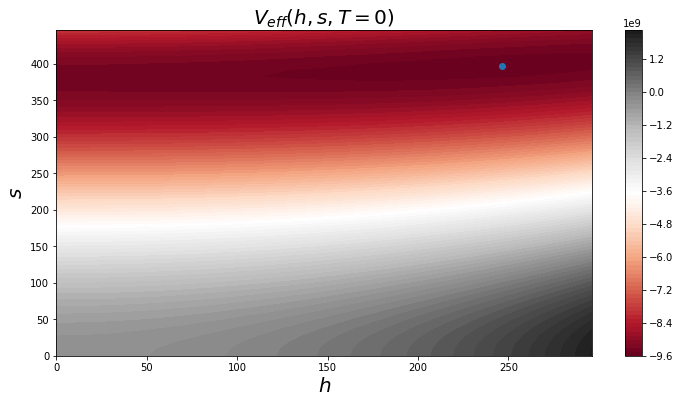

In [9]:
clevs=50
myN = 100
Temp=0
box=(0,v+50,-0,m.u+np.sign(m.u)*50)
xmin,xmax,ymin,ymax=box
x=np.linspace(xmin,xmax,clevs)
y=np.linspace(ymin,ymax,clevs)
X,Y=np.meshgrid(x,y)
Z_V=[]
for i in x:
    Z_V_row=[]
    for j in y:
        Z_V_row.append([m.Vtot([i,j],Temp)])
    Z_V.append(Z_V_row)
Z_V=np.array(Z_V).T[0]


fig, ax1 = plt.subplots(1,1,figsize=(12,6))
ax1.set_title("$V_{eff}(h,s, T=$%1.f"%Temp + ")",size=20)
ax1.set_xlabel('$h$',size=20)
ax1.set_ylabel('$s$',size=20)
cf1 = ax1.contourf(X,Y,Z_V,myN,cmap="RdGy")
fig.colorbar(cf1, ax=ax1)
ax1.scatter(v,m.u)
plt.show()

In [ ]:
nuc_dict=find_nucleation(m)
tntrans=my_find_Trans(m)

phi_stable=tntrans["low_vev"]
phi_meta=tntrans["high_vev"]
Tnuc=tntrans["Tnuc"]
dT=abs(m.phases[tntrans["high_phase"]].T[0]-m.phases[tntrans["low_phase"]].T[-1])
Delta_rho=m.energyDensity(phi_meta,Tnuc,include_radiation=True)-m.energyDensity(phi_stable,Tnuc,include_radiation=True)
alpha=alpha_GW(Tnuc,Delta_rho)

doing (-3, -3)
Tracing phase starting at x = [246.19999995  71.58079955] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
...........................................................................................................doing (-5, -4)
Tracing phase starting at x = [246.19999995  71.58079955] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
..............................................................................doing (-5, -3)
Tracing phase starting at x = [246.19999995  71.58079955] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
...........................................................................

In [10]:


m=model1(ms = ms_val, theta = theta_val, muhs= 0 , u = u_val, mu3 = 0)
m.find_counter_terms()
thbool=m.theory_consistent()
m.print_couplings()
dmuh,dmus,dlam,dlams,dlammix = m.counter_terms
Pih=g1**2/16 + 3*g**2/16 + m.lamh/2 + 1/4 + m.lammix/24
Pis=m.lammix/6 + m.lams/4
lamh_tilde=m.lamh - m.lammix**2/4/m.lams
dict_out={'ms':m.ms,'theta':m.theta, 'u':m.u,"lamh":m.lamh,"lams":m.lams,"lammix":m.lammix,"muh2":m.muh2,"mus2":m.mus2,
         "dmuh":dmuh,"dmus":dmus,"dlam":dlam,"dlams":dlams,"dlammix":dlammix,"Pih":Pih,"Pis":Pis,"lamh_tilde":lamh_tilde}
if thbool==True:
    dict_out.update({ "th_bool":thbool})
    try:
        alltrans=m.findAllTransitions()
        index=0
        count_trans=0
        alpha_list=[]
        dT_list=[]
        trans_types=[]
        for elem in alltrans:
            if elem["trantype"]==1:
                count_trans+=1
                phi_stable=elem["low_vev"]
                phi_meta=elem["high_vev"]
                SymNR=np.sum(m.findMinimum([0,0],1000)**2)**0.5>10
                dh,ds=abs(phi_meta-phi_stable)
                trans_types.append(trans_class(SymNR))
                Tnuc=elem["Tnuc"]
                #Tc=elem["Tcrit"]
                dT=abs(m.phases[elem["high_phase"]].T[0]-m.phases[elem["low_phase"]].T[-1])
                dT_list.append(dT)
                Delta_rho=m.energyDensity(phi_meta,Tnuc,include_radiation=True)-m.energyDensity(phi_stable,Tnuc,include_radiation=True)
                alpha=alpha_GW(Tnuc,Delta_rho)
                alpha_list.append(alpha)
                dict_out.update({ "h_low_"+str(index):phi_stable[0],"s_low_"+str(index):phi_stable[1],
                                 "h_high_"+str(index):phi_meta[0],"s_high_"+str(index):phi_meta[1],
                                 "Tnuc_"+str(index):Tnuc,"dT_"+str(index):dT,"alpha_"+str(index):alpha})
                index+=1
        relevant_index=alpha_list.index(max(alpha_list))
        dict_out.update({"num_FOPT":count_trans,"alpha_max":max(alpha_list),
                         "dT_max":dT_list[relevant_index],
                        "tran_type":trans_types[relevant_index]})
    except:
        print("error occured")
                        
    

Counter terms are given by: 

[dmuh,dmus,dlam,dlams,dlammix]
[639.848688645453, 16862.129890463046, -0.05494136395001583, 0.108426219899538, -0.02519482382141686]
..............
 Derivatives of CW potential are given by:
[1465929.0378723145, -13166451.772109985, 12614.700317382812, -67330.94660258293, 2461.75]
value of CW at the minimum
-1118149837.6984622
Model is theoretically consistent 

Potential parameters are given by 
 
mus2= 280173.2241210234 muh2= -49483.30318242915 lamh= 0.21237980387507027 lams= 1.93120566330415 lammix= -0.7918140095947136 

Model parameters are 

ms= 786.4101148104463 theta= 0.12980050817316766 muhs= 0 u= 396.86661975760086 mu3= 0
Tracing phase starting at x = [246.19999858 396.86661914] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
......................................................................................................................................................................................................................
Tracing p

In [11]:
dict_out

{'ms': 786.4101148104463,
 'theta': 0.12980050817316766,
 'u': 396.86661975760086,
 'lamh': 0.21237980387507027,
 'lams': 1.93120566330415,
 'lammix': -0.7918140095947136,
 'muh2': -49483.30318242915,
 'mus2': 280173.2241210234,
 'dmuh': 639.848688645453,
 'dmus': 16862.129890463046,
 'dlam': -0.05494136395001583,
 'dlams': 0.108426219899538,
 'dlammix': -0.02519482382141686,
 'Pih': 0.4076991334498323,
 'Pis': 0.3508324142269186,
 'lamh_tilde': 0.13121684985833457,
 'th_bool': True,
 'h_low_0': -1.3615079923627713e-06,
 's_low_0': 261.10532158333336,
 'h_high_0': -1.6864179763442616e-05,
 's_high_0': 4.4602934954451144e-05,
 'Tnuc_0': 792.6985671331518,
 'dT_0': 76.06512071754628,
 'alpha_0': 0.0008404376340469172,
 'num_FOPT': 1,
 'alpha_max': 0.0008404376340469172,
 'dT_max': 76.06512071754628,
 'tran_type': 's-sym'}